In [9]:
from asyncio import get_event_loop
from websockets import serve
from matplotlib import pyplot as plt
from matplotlib import patches
from skimage import io, transform
from pylibdmtx.pylibdmtx import decode
from multiprocessing import Pool
from io import BytesIO
from json import dumps, loads
from uuid import uuid4
from math import cos, sin, pi
%matplotlib inline

In [10]:
sorted(glob("*"))

['07c2c6e2-3717-4381-96a7-eb5e522dedae.json',
 '07c2c6e2-3717-4381-96a7-eb5e522dedae.png',
 '717d3b1c-341c-438b-aed4-4d429db40d71.json',
 '717d3b1c-341c-438b-aed4-4d429db40d71.png',
 '8beea9d8-2167-4f7d-b140-56bab55bf2aa.json',
 '8beea9d8-2167-4f7d-b140-56bab55bf2aa.png',
 '__pycache__',
 'e68b03ff-4c6a-4c86-b4e9-d41d39160d9b.json',
 'e68b03ff-4c6a-4c86-b4e9-d41d39160d9b.png',
 'newtest.ipynb',
 'requirements.txt',
 'wsserver.py']

In [11]:
filesets = [
    ['07c2c6e2-3717-4381-96a7-eb5e522dedae.json', '07c2c6e2-3717-4381-96a7-eb5e522dedae.png'],
    ['8beea9d8-2167-4f7d-b140-56bab55bf2aa.json', '8beea9d8-2167-4f7d-b140-56bab55bf2aa.png'],
    ['e68b03ff-4c6a-4c86-b4e9-d41d39160d9b.json', 'e68b03ff-4c6a-4c86-b4e9-d41d39160d9b.png'],
    ['717d3b1c-341c-438b-aed4-4d429db40d71.json', '717d3b1c-341c-438b-aed4-4d429db40d71.png']
]
fileset = 3

In [12]:
meta = load(open(filesets[fileset][0]))
grid = meta['grid']
iscale = meta['scale']

In [14]:
def decode_thread(pospos):
	col, xs, row, ys, well, effort = pospos

	res = decode(well, max_count=1)
	if res:
		return {'row': row+1, 'xs': xs, 'col': col+1, 'ys': ys, 'barcode': res[0].data.decode()}
	else:
		found = False
		for i in range(effort):
			res = decode(transform.rotate(well, i), max_count=1)
			if res:
				return {'row': row+1, 'xs': xs, 'col': col+1, 'ys': ys, 'barcode': res[0].data.decode()}
		if not found:
			return {'row': row+1, 'xs': xs, 'col': col+1, 'ys': ys, 'barcode': 'failed'}


def read_dem_wells(im, meta, effort=10):
	grid = meta['grid']
	iscale = meta['scale']
	scale = im.shape[1] / iscale
	fig, ax = plt.subplots(1, figsize=(10, 20))
	ax.imshow(im)
	rect = patches.Rectangle((grid['left'] * scale, grid['top'] * scale), width=grid['width'] * grid['scaleX'] * scale,
													 height=grid['height'] * grid['scaleY'] * scale, angle=grid['angle'], linewidth=1,
													 edgecolor='r', facecolor='none')
	ar_pa = patches.Arrow(grid['left'] * scale, grid['top'] * scale, cos(((grid['angle'] - 90) / 360) * (2 * pi)) * 50,
												sin(((grid['angle'] - 90) / 360) * (2 * pi)) * 50, color='green', width=10)
	ax.add_patch(ar_pa)
	ax.add_patch(rect)

	grid_size = max(grid['width'] / 12, grid['height'] / 12) * scale
	width = grid_size * grid['scaleX'] * 1.36
	height = grid_size * grid['scaleY'] * 1.35
	ori_x = grid['left'] * scale
	ori_y = grid['top'] * scale
	angle = (grid['angle'] / 360) * 2 * pi
	pps = []
	for row in range(8):
		for col in range(12):
			dx = ori_x + width * col * cos(angle) - height * row * sin(angle)
			dy = ori_y + width * col * sin(angle) + height * row * cos(angle)

			dx1 = ori_x + width * col * cos(angle) - height * row * sin(angle)
			dx2 = ori_x + width * (col) * cos(angle) - height * (row + 1) * sin(angle)
			dx3 = ori_x + width * (col + 1) * cos(angle) - height * (row + 1) * sin(angle)
			dx4 = ori_x + width * (col + 1) * cos(angle) - height * row * sin(angle)
			dxs = [dx1, dx2, dx3, dx4]
			dy1 = ori_y + width * col * sin(angle) + height * row * cos(angle)
			dy2 = ori_y + width * col * sin(angle) + height * (row + 1) * cos(angle)
			dy3 = ori_y + width * (col + 1) * sin(angle) + height * (row + 1) * cos(angle)
			dy4 = ori_y + width * (col + 1) * sin(angle) + height * row * cos(angle)
			dys = [dy1, dy2, dy3, dy4]

			well = im[int(min(dys)):int(max(dys)), int(min(dxs)):int(max(dxs))]
			pps.append([col, dx, row, dy, well, effort])

	with Pool(8) as p:
		rar = p.map(decode_thread, pps)

	for irar in rar:
		if irar['barcode'] == 'failed':
			color = 'red'
		else:
			color = 'green'
		mrect = patches.Rectangle((irar['xs'], irar['ys']), width=width, height=height, angle=grid['angle'], linewidth=1,edgecolor=color,facecolor='none')
		ax.add_patch(mrect)

	f = BytesIO()
	ax.axis('off')
	fig.savefig(f, format='png', bbox_inches='tight')
	return rar, f.getvalue()

([{'row': 1,
   'xs': 37.73992197659298,
   'col': 1,
   'ys': 46.366189856957085,
   'barcode': '0153128283'},
  {'row': 1,
   'xs': 202.45333139141746,
   'col': 2,
   'ys': 46.366189856957085,
   'barcode': '0153128288'},
  {'row': 1,
   'xs': 367.16674080624193,
   'col': 3,
   'ys': 46.366189856957085,
   'barcode': '0153128736'},
  {'row': 1,
   'xs': 531.8801502210664,
   'col': 4,
   'ys': 46.366189856957085,
   'barcode': '0153128268'},
  {'row': 1,
   'xs': 696.5935596358909,
   'col': 5,
   'ys': 46.366189856957085,
   'barcode': '0153128783'},
  {'row': 1,
   'xs': 861.3069690507153,
   'col': 6,
   'ys': 46.366189856957085,
   'barcode': '0153128771'},
  {'row': 1,
   'xs': 1026.0203784655398,
   'col': 7,
   'ys': 46.366189856957085,
   'barcode': '0153128278'},
  {'row': 1,
   'xs': 1190.7337878803642,
   'col': 8,
   'ys': 46.366189856957085,
   'barcode': '0153128806'},
  {'row': 1,
   'xs': 1355.4471972951887,
   'col': 9,
   'ys': 46.366189856957085,
   'barcode': '0

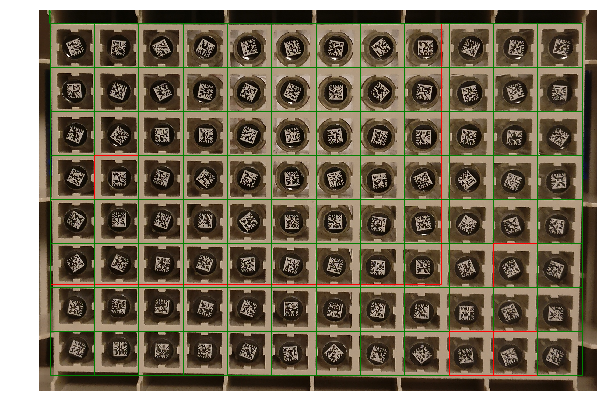

In [15]:
read_dem_wells(io.imread(filesets[fileset][1]), meta, 10)

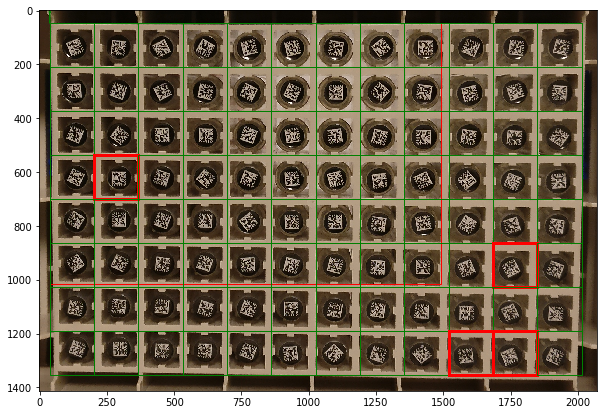

In [27]:
im = io.imread(filesets[fileset][1])
scale = im.shape[1]/iscale
fig,ax = plt.subplots(1, figsize=(10,20))
ax.imshow(im)
rect = patches.Rectangle((grid['left']*scale,grid['top']*scale),width=grid['width']*grid['scaleX']*scale,height=grid['height']*grid['scaleY']*scale,angle=grid['angle'],linewidth=1,edgecolor='r',facecolor='none')
ar_pa = patches.Arrow(grid['left']*scale, grid['top']*scale, cos(((grid['angle']-90)/360)*(2*pi))*50, sin(((grid['angle']-90)/360)*(2*pi))*50, color = 'green', width=10)
ax.add_patch(ar_pa)
ax.add_patch(rect)

grid_size = max(grid['width']/12, grid['height']/12)*scale
width=grid_size*grid['scaleX']*1.36
height=grid_size*grid['scaleY']*1.35
ori_x = grid['left']*scale
ori_y = grid['top']*scale
angle = (grid['angle']/360)*2*pi
ress = []
wells = []
for row in range(8):
    for col in range(12):        
        dx = ori_x+width*col*cos(angle)-height*row*sin(angle)
        dy = ori_y+width*col*sin(angle)+height*row*cos(angle)
        
        dx1 = ori_x+width*col*cos(angle)-height*row*sin(angle)
        dx2 = ori_x+width*(col)*cos(angle)-height*(row+1)*sin(angle)
        dx3 = ori_x+width*(col+1)*cos(angle)-height*(row+1)*sin(angle)
        dx4 = ori_x+width*(col+1)*cos(angle)-height*row*sin(angle)
        dxs = [dx1,dx2,dx3,dx4]
        dy1 = ori_y+width*col*sin(angle)+height*row*cos(angle)
        dy2 = ori_y+width*col*sin(angle)+height*(row+1)*cos(angle)
        dy3 = ori_y+width*(col+1)*sin(angle)+height*(row+1)*cos(angle)
        dy4 = ori_y+width*(col+1)*sin(angle)+height*row*cos(angle)
        dys = [dy1,dy2,dy3,dy4]

        #(min(dxs), min(dys)), width=max(dxs)-min(dxs), height=max(dys)-min(dys), linewidth=3,edgecolor='g',facecolor='none')
        well = im[int(min(dys)):int(max(dys)), int(min(dxs)):int(max(dxs))]
        
        res = decode(well, max_count=1)
        
        if res:
            mrect = patches.Rectangle((dx, dy), width=width, height=height, angle=grid['angle'],linewidth=1,edgecolor='green',facecolor='none')
        else:
            found = False
            for i in range(100):
                res = decode(transform.rotate(well, i), max_count=1)
                if res:
                    mrect = patches.Rectangle((dx, dy), width=width, height=height, angle=grid['angle'],linewidth=1,edgecolor='green',facecolor='none')
                    break
            if not found:
                mrect = patches.Rectangle((dx, dy), width=width, height=height, angle=grid['angle'],linewidth=3,edgecolor='r',facecolor='none')
                wells.append([row,col, well])
        ax.add_patch(mrect)
        ress.append(res)

plt.show()

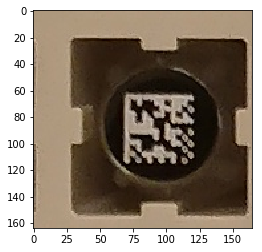

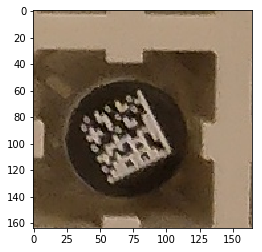

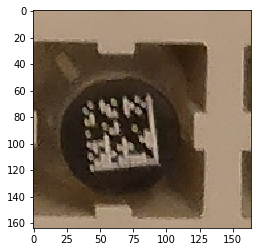

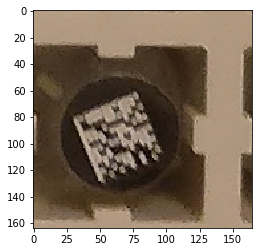

In [24]:
for i in wells:
    f, ax = plt.subplots()
    plt.imshow(i[2])

In [98]:
im2 = io.imread("../client/png2.png")
well = im[int(min(dys)):int(max(dys)), int(min(dxs)):int(max(dxs))]

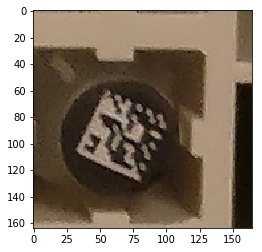

In [99]:
plt.imshow(well)

In [100]:
decode(well, timeout=1000, deviation=40, threshold=20)

[Decoded(data=b'0153126648', rect=Rect(left=31, top=57, width=72, height=25))]

In [108]:
im.shape

(1413, 2073, 4)

In [106]:
io.imread("../client/png2.png")

array([[[ 57,  38,  21, 255],
        [ 56,  37,  22, 255],
        [ 56,  37,  22, 255],
        ...,
        [ 50,  34,  21, 255],
        [ 49,  33,  20, 255],
        [ 48,  32,  19, 255]],

       [[ 57,  38,  21, 255],
        [ 56,  37,  22, 255],
        [ 56,  37,  22, 255],
        ...,
        [ 49,  33,  20, 255],
        [ 48,  32,  19, 255],
        [ 47,  31,  18, 255]],

       [[ 56,  37,  20, 255],
        [ 56,  37,  20, 255],
        [ 56,  37,  20, 255],
        ...,
        [ 48,  32,  19, 255],
        [ 47,  31,  18, 255],
        [ 47,  31,  18, 255]],

       ...,

       [[122, 100,  77, 255],
        [121,  99,  76, 255],
        [121,  99,  76, 255],
        ...,
        [ 74,  53,  36, 255],
        [ 71,  49,  35, 255],
        [ 72,  50,  36, 255]],

       [[123, 101,  78, 255],
        [123, 101,  78, 255],
        [122, 100,  77, 255],
        ...,
        [ 76,  55,  38, 255],
        [ 73,  51,  37, 255],
        [ 75,  53,  39, 255]],

       [[123